In [ ]:
# If using an R kernel, this code should work directly.
# Just ensure the filePath is correct.
library(data.table)
library(ggplot2)
library(tidyr)

# Set file path and load data
# Ensure the file path is correct and the file exists at this location.
filePath <- "/content/QVI_data.csv"
data <- fread(filePath) # Fixed: Removed the extra concatenation

In [ ]:
data[, YEARMONTH := format(as.Date(DATE, "%Y-%m-%d"), "%Y%m")]

In [ ]:
measureOverTime <- data[, .(
  totSales = sum(TOT_SALES),
  nCustomers = uniqueN(LYLTY_CARD_NBR),
  nTxnPerCust = .N / uniqueN(LYLTY_CARD_NBR),
  nChipsPerTxn = sum(PROD_QTY) / .N,
  avgPricePerUnit = sum(TOT_SALES) / sum(PROD_QTY)
), by = .(STORE_NBR, YEARMONTH)][order(STORE_NBR, YEARMONTH)]

In [ ]:
storesWithFullObs <- unique(measureOverTime[, .N, by = STORE_NBR][N == 12, STORE_NBR])
preTrialMeasures <- measureOverTime[YEARMONTH < "201902" & STORE_NBR %in% storesWithFullObs]

In [ ]:
calculateCorrelation <- function(inputTable, metricCol, storeComparison) {
  storeNumbers <- unique(inputTable[, STORE_NBR])
  trialData <- inputTable[STORE_NBR == storeComparison, .(YEARMONTH, value = eval(metricCol))]
  corrTable <- data.table()

  for (store in storeNumbers[storeNumbers != storeComparison]) {
    controlData <- inputTable[STORE_NBR == store, .(YEARMONTH, value = eval(metricCol))]
    merged <- merge(trialData, controlData, by = "YEARMONTH")
    corr <- cor(merged$value.x, merged$value.y)
    corrTable <- rbind(corrTable, data.table(Store1 = storeComparison, Store2 = store, corr_measure = corr))
  }

  return(corrTable)
}

In [ ]:
calculateMagnitudeDistance <- function(inputTable, metricCol, storeComparison) {
  storeNumbers <- unique(inputTable[, STORE_NBR])
  distTable <- data.table()

  for (store in storeNumbers[storeNumbers != storeComparison]) {
    d1 <- inputTable[STORE_NBR == storeComparison, .(YEARMONTH, val1 = eval(metricCol))]
    d2 <- inputTable[STORE_NBR == store, .(YEARMONTH, val2 = eval(metricCol))]
    merged <- merge(d1, d2, by = "YEARMONTH")
    merged[, measure := abs(val1 - val2)]
    merged[, `:=`(Store1 = storeComparison, Store2 = store)]
    distTable <- rbind(distTable, merged[, .(Store1, Store2, YEARMONTH, measure)])
  }

  minMax <- distTable[, .(minDist = min(measure), maxDist = max(measure)), by = .(Store1, YEARMONTH)]
  distTable <- merge(distTable, minMax, by = c("Store1", "YEARMONTH"))
  distTable[, magnitudeMeasure := 1 - (measure - minDist)/(maxDist - minDist)]

  finalTable <- distTable[, .(mag_measure = mean(magnitudeMeasure, na.rm = TRUE)), by = .(Store1, Store2)]
  return(finalTable)
}

In [ ]:
# Calculate correlation and magnitude scores
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

# Pass the column names as quoted expressions to calculateMagnitudeDistance
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
# Merge and compute score
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))
score_nSales[, scoreNSales := 0.5 * corr_measure + 0.5 * mag_measure]

score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))
score_nCustomers[, scoreNCust := 0.5 * corr_measure + 0.5 * mag_measure]

# Final control store score
score_Control <- merge(score_nSales[, .(Store1, Store2, scoreNSales)],
                       score_nCustomers[, .(Store1, Store2, scoreNCust)],
                       by = c("Store1", "Store2"))

score_Control[, finalControlScore := (scoreNSales + scoreNCust) / 2]

# Pick best match (not the same store)
control_store <- score_Control[order(-finalControlScore)][1, Store2]
print(control_store)

[1] 233


In [ ]:
# Scale factor: pre-trial total sales
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store, sum(totSales)] /
                                preTrialMeasures[STORE_NBR == control_store, sum(totSales)]

# Apply to full dataset
measureOverTimeSales <- measureOverTime[STORE_NBR %in% c(trial_store, control_store)]
measureOverTimeSales[, scaledSales := ifelse(STORE_NBR == control_store,
                                             totSales * scalingFactorForControlSales,
                                             totSales)]


In [ ]:
trial_store <- 88

# Calculate correlations
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

# Calculate magnitude distances
# Ensure the column names are passed as quoted expressions using quote()
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

# Merge and compute average scores
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))
score_nSales[, scoreNSales := 0.5 * corr_measure + 0.5 * mag_measure]

score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))
score_nCustomers[, scoreNCust := 0.5 * corr_measure + 0.5 * mag_measure]

score_Control <- merge(score_nSales[, .(Store1, Store2, scoreNSales)],
                       score_nCustomers[, .(Store1, Store2, scoreNCust)],
                       by = c("Store1", "Store2"))
score_Control[, finalControlScore := (scoreNSales + scoreNCust) / 2]

# Find top matching store
control_store_88 <- score_Control[order(-finalControlScore)][1, Store2]
print(paste("Control store for trial store 88 is:", control_store_88))

[1] "Control store for trial store 88 is: 237"


In [ ]:
# Calculate magnitude distances
# Ensure the column names are passed as quoted expressions
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

# Merge and compute average scores
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))

# Continue with the rest of the merge and scoring logic
score_nSales[, scoreNSales := 0.5 * corr_measure + 0.5 * mag_measure]

score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))
score_nCustomers[, scoreNCust := 0.5 * corr_measure + 0.5 * mag_measure]

# Final control store score
score_Control <- merge(score_nSales[, .(Store1, Store2, scoreNSales)],
                       score_nCustomers[, .(Store1, Store2, scoreNCust)],
                       by = c("Store1", "Store2"))

score_Control[, finalControlScore := (scoreNSales + scoreNCust) / 2]

# Pick best match (not the same store)
control_store <- score_Control[order(-finalControlScore)][1, Store2]
print(control_store)

[1] 233


In [ ]:
# Scale factor: pre-trial total sales
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store, sum(totSales)] /
                                preTrialMeasures[STORE_NBR == control_store, sum(totSales)]

# Apply to full dataset
measureOverTimeSales <- measureOverTime[STORE_NBR %in% c(trial_store, control_store)]
measureOverTimeSales[, scaledSales := ifelse(STORE_NBR == control_store,
                                             totSales * scalingFactorForControlSales,
                                             totSales)]


In [ ]:
percentageDiff <- dcast(measureOverTimeSales[, .(YEARMONTH, STORE_NBR, scaledSales)],
                        YEARMONTH ~ STORE_NBR, value.var = "scaledSales")
setnames(percentageDiff, c("YEARMONTH", "Control", "Trial"))  # Use correct column names
percentageDiff[, percDiff := abs(Trial - Control) / Control]


In [ ]:
# Standard deviation of percentage differences pre-trial
stdDev <- sd(percentageDiff[YEARMONTH < "201902", percDiff])

# Compute t-values for trial period (Feb–Apr 2019)
percentageDiff[, t_value := (percDiff - 0) / stdDev]  # Null hypothesis: no difference
percentageDiff[, TransactionMonth := as.Date(paste0(substr(YEARMONTH, 1, 4), "-",
                                                    substr(YEARMONTH, 5, 6), "-01"))]

# Show only trial period months
percentageDiff[YEARMONTH >= "201902" & YEARMONTH <= "201904"]

YEARMONTH,Control,Trial,percDiff,t_value,TransactionMonth
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
201902,235.0,249.7626,0.06281967,1.280255,2019-02-01
201903,278.5,203.8022,0.26821470,5.466175,2019-03-01
201904,263.5,162.3457,0.38388727,7.823564,2019-04-01


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in geom_rect(data = subset(pastSales, TransactionMonth >= as.Date("2019-02-01") & :
“All aesthetics have length 1, but the data has 12 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


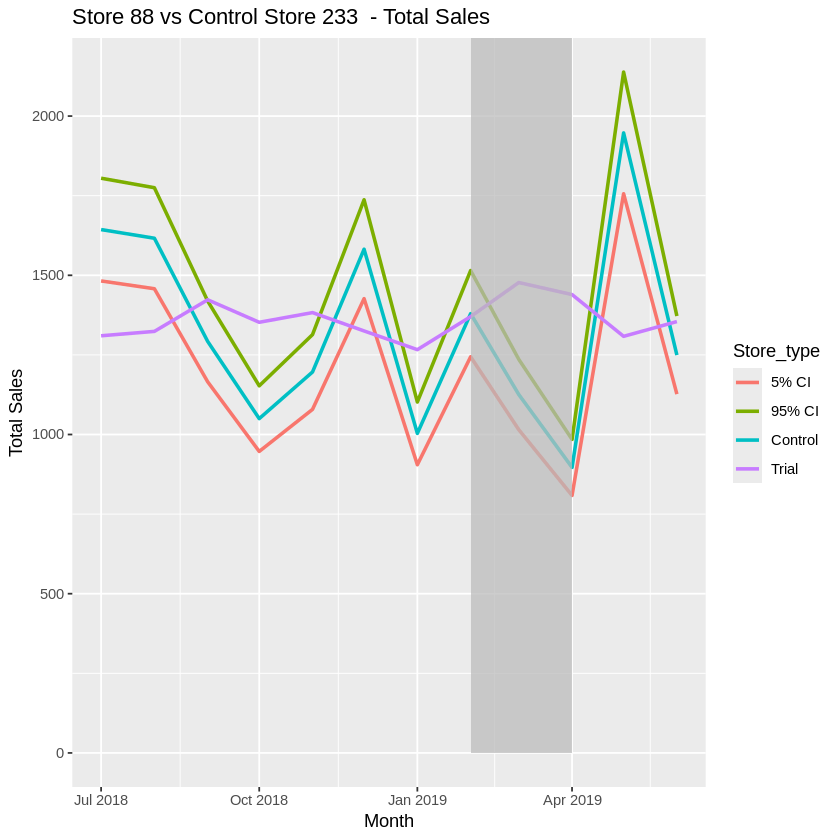

In [ ]:
# Create Store_type and scaled total sales for plotting
measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                                            ifelse(STORE_NBR == control_store, "Control", "Other"))]
measureOverTimeSales[, TransactionMonth := as.Date(paste0(substr(YEARMONTH, 1, 4), "-",
                                                          substr(YEARMONTH, 5, 6), "-01"))]

# Create bounds (95% CI)
pastSales_95 <- measureOverTimeSales[Store_type == "Control", .(TransactionMonth, totSales = scaledSales * (1 + 2 * stdDev))]
pastSales_5 <- measureOverTimeSales[Store_type == "Control", .(TransactionMonth, totSales = scaledSales * (1 - 2 * stdDev))]

pastSales <- rbind(
  measureOverTimeSales[Store_type %in% c("Trial", "Control"), .(TransactionMonth, totSales = scaledSales, Store_type)],
  data.table(TransactionMonth = pastSales_95$TransactionMonth, totSales = pastSales_95$totSales, Store_type = "95% CI"),
  data.table(TransactionMonth = pastSales_5$TransactionMonth, totSales = pastSales_5$totSales, Store_type = "5% CI")
)

# Plot
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_line(size = 1) +
  geom_rect(data = subset(pastSales, TransactionMonth >= as.Date("2019-02-01") &
                                        TransactionMonth <= as.Date("2019-04-01")),
            aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth),
                ymin = 0, ymax = Inf), fill = "grey", alpha = 0.1, inherit.aes = FALSE) +
  labs(title = paste("Store", trial_store, "vs Control Store", control_store, " - Total Sales"),
       y = "Total Sales", x = "Month")

In [ ]:
# Scaling factor
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store, sum(nCustomers)] /
                               preTrialMeasures[STORE_NBR == control_store, sum(nCustomers)]

# Apply scaling
measureOverTimeCusts <- measureOverTime[STORE_NBR %in% c(trial_store, control_store)]
measureOverTimeCusts[, scaledCusts := ifelse(STORE_NBR == control_store,
                                             nCustomers * scalingFactorForControlCust,
                                             nCustomers)]

# Percent diff
percentageDiffCusts <- dcast(measureOverTimeCusts[, .(YEARMONTH, STORE_NBR, scaledCusts)],
                             YEARMONTH ~ STORE_NBR, value.var = "scaledCusts")
setnames(percentageDiffCusts, c("YEARMONTH", "Control", "Trial"))
percentageDiffCusts[, percDiff := abs(Trial - Control) / Control]

# Standard deviation
stdDevCust <- sd(percentageDiffCusts[YEARMONTH < "201902", percDiff])


In [ ]:
# Create bounds
# Add the Store_type column to measureOverTimeCusts
measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                                            ifelse(STORE_NBR == control_store, "Control", "Other"))]

pastCust_95 <- measureOverTimeCusts[STORE_NBR == control_store,
                                   .(TransactionMonth, nCustomers = scaledCusts * (1 + 2 * stdDevCust))]
pastCust_5 <- measureOverTimeCusts[STORE_NBR == control_store,
                                  .(TransactionMonth, nCustomers = scaledCusts * (1 - 2 * stdDevCust))]

pastCust <- rbind(
  measureOverTimeCusts[Store_type %in% c("Trial", "Control"), .(TransactionMonth, nCustomers = scaledCusts, Store_type)],
  data.table(TransactionMonth = pastCust_95$TransactionMonth, nCustomers = pastCust_95$nCustomers, Store_type = "95% CI"),
  data.table(TransactionMonth = pastCust_5$TransactionMonth, nCustomers = pastCust_5$nCustomers, Store_type = "5% CI")
)